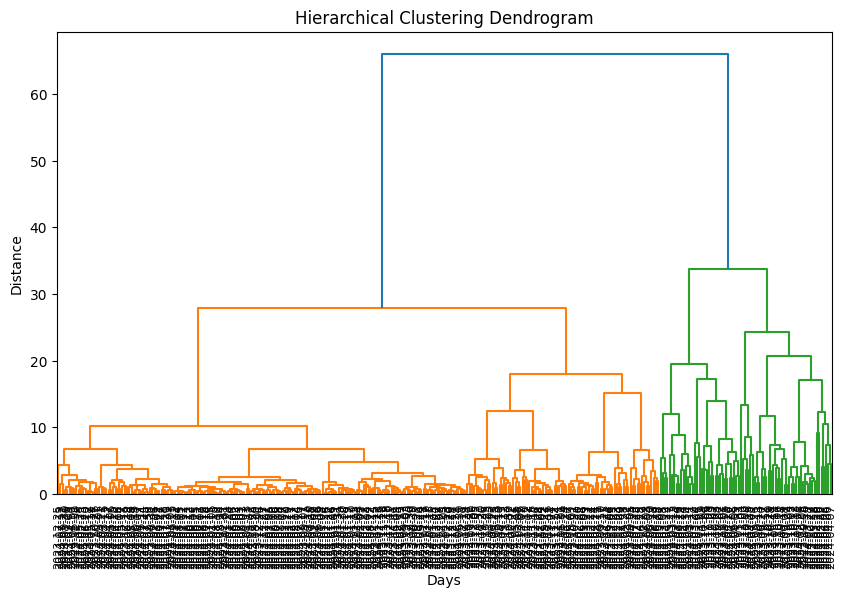

In [2]:
import pandas as pd

# Load the data from the uploaded Excel file
file_path = 'Days_without_high_volatile_days(92.08 per cent).xlsx'

# Load all sheets to inspect the structure of the file
xls = pd.ExcelFile(file_path)

# Checking the names of the sheets to understand the file's structure
sheet_names = xls.sheet_names

# Load the first sheet to inspect the data
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Convert the 'Datetime' column to pandas datetime type for easier manipulation
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Define the time segments
time_segments = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '00:00')
]

# Initialize a list to store the features for each day
features = []

# Group the data by day
data['Day'] = data['Datetime'].dt.date
grouped_by_day = data.groupby('Day')

# Function to calculate features for each time segment
def calculate_features_for_day(day_data, segments):
    day_features = []
    for start_time, end_time in segments:
        segment_data = day_data.between_time(start_time, end_time)['USEP (c/kWh)']
        if not segment_data.empty:
            max_value = segment_data.max()
            std_dev = segment_data.std()
            is_max_over_20 = 1 if max_value > 24.14 else 0 #17.78+6.36=24,14
        else:
            max_value = std_dev = is_max_over_20 = 0
        day_features.extend([max_value, std_dev, is_max_over_20])
    return day_features

# Iterate over each day, calculate the required features, and append to the list
for day, day_data in grouped_by_day:
    # Convert to time-indexed dataframe for between_time usage
    day_data = day_data.set_index('Datetime')
    day_features = calculate_features_for_day(day_data, time_segments)
    features.append([day] + day_features)

# Create a dataframe for the calculated features
columns = ['Day'] + [f'Segment{i+1}_{metric}' for i in range(6) for metric in ['Max', 'Std', 'MaxOver20']]
features_df = pd.DataFrame(features, columns=columns)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Extracting only the feature columns for clustering
feature_columns = features_df.columns[1:]  # Exclude the 'Day' column
X = features_df[feature_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform hierarchical clustering using the Ward method
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Days")
plt.ylabel("Distance")
dendrogram(Z, labels=features_df['Day'].values, leaf_rotation=90, leaf_font_size=8)
plt.show()


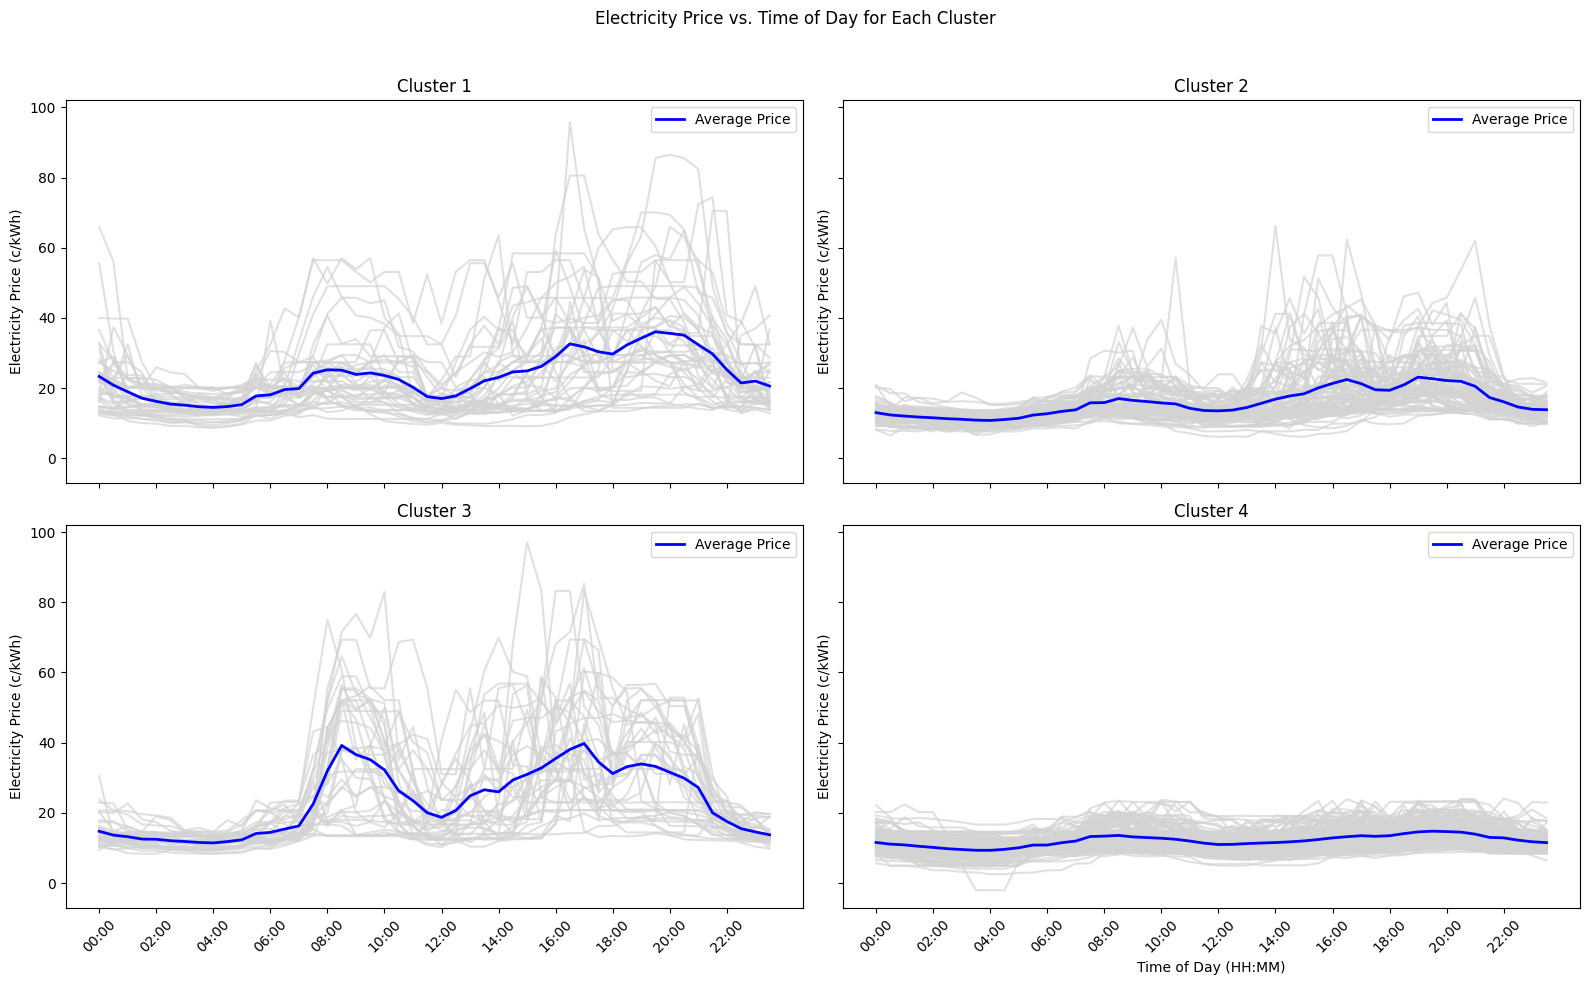

In [3]:
# Perform agglomerative clustering with 4 clusters
agg_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clusters = agg_cluster.fit_predict(X_scaled)

# Add the cluster labels to the original features dataframe
features_df['Cluster'] = clusters

# Convert time-of-day values to string format for proper plotting (again for safety)
data['TimeOfDay'] = data['Datetime'].dt.strftime('%H:%M')

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each cluster and plot the data for each cluster
for cluster_num in range(4):
    # Get the days that belong to the current cluster
    cluster_days = features_df[features_df['Cluster'] == cluster_num]['Day']

    # Filter the original data for these days
    cluster_data = data[data['Day'].isin(cluster_days)]

    # Group by TimeOfDay to get the average electricity price for the cluster
    cluster_avg = cluster_data.groupby('TimeOfDay')['USEP (c/kWh)'].mean()

    # Plot individual days within the cluster
    for day in cluster_days:
        day_data = data[data['Day'] == day]
        axes[cluster_num].plot(day_data['TimeOfDay'], day_data['USEP (c/kWh)'], color='lightgray', alpha=0.7)

    # Plot the average price for the cluster
    axes[cluster_num].plot(cluster_avg.index, cluster_avg.values, color='blue', linewidth=2, label='Average Price')

    # Set title and labels
    axes[cluster_num].set_title(f'Cluster {cluster_num + 1}')
    axes[cluster_num].set_ylabel('Electricity Price (c/kWh)')
    axes[cluster_num].set_xticks(cluster_avg.index[::4])  # Reduce the number of x-ticks for clarity
    axes[cluster_num].set_xticklabels(cluster_avg.index[::4], rotation=45)
    axes[cluster_num].legend()

# Set common x-axis label
plt.xlabel('Time of Day (HH:MM)')
plt.suptitle('Electricity Price vs. Time of Day for Each Cluster')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [4]:
# Calculate the proportion of days in each cluster
cluster_proportions = features_df['Cluster'].value_counts(normalize=True).sort_index()

# Convert proportions to percentages
cluster_proportions = (cluster_proportions * 100).round(2)

# Create a table to display the proportions
proportion_table = pd.DataFrame({
    'Cluster': cluster_proportions.index + 1,  # To match cluster numbering (1-based)
    'Proportion (%)': cluster_proportions.values
})


# Show the table
proportion_table


,Cluster,Proportion (%)
0,1,11.87
1,2,24.93
2,3,10.39
3,4,52.82


In [ ]:
import pandas as pd

# Load the original data
file_path = 'Days_without_high_volatile_days(92.08 per cent).xlsx'
original_data = pd.read_excel(file_path, sheet_name='Sheet1')
original_data['Datetime'] = pd.to_datetime(original_data['Datetime'])  # Convert to datetime

# Create the 'Day' column in the original data
original_data['Day'] = original_data['Datetime'].dt.date

# Merge with features_df to get cluster assignments for each row
merged_data = pd.merge(original_data, features_df[['Day', 'Cluster']], on='Day', how='left')

# Filter data for cluster 3
cluster_3_data = merged_data[merged_data['Cluster'] == 2]

# Filter data for clusters 1, 2, and 4
other_clusters_data = merged_data[merged_data['Cluster'].isin([0, 1, 3])]

# Save the filtered data to separate Excel files
cluster_3_data[['Datetime', 'USEP (c/kWh)']].to_excel("cluster_3_days.xlsx", index=False)
other_clusters_data[['Datetime', 'USEP (c/kWh)']].to_excel("other_clusters_days.xlsx", index=False)

<ipython-input-5-a1324593dbc8>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Date').apply(calculate_features).reset_index()


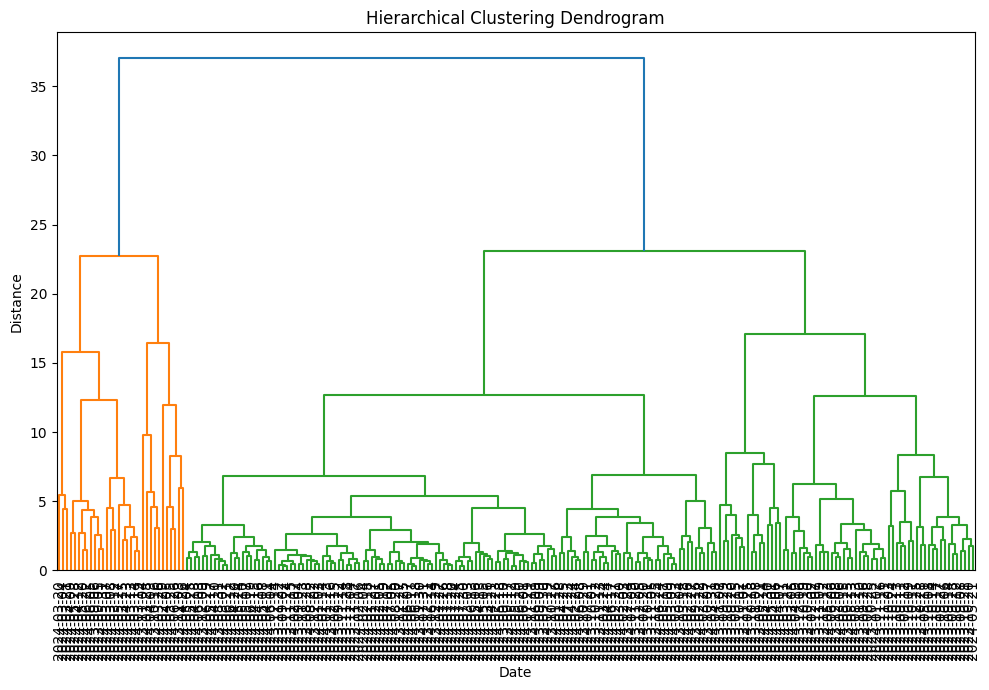

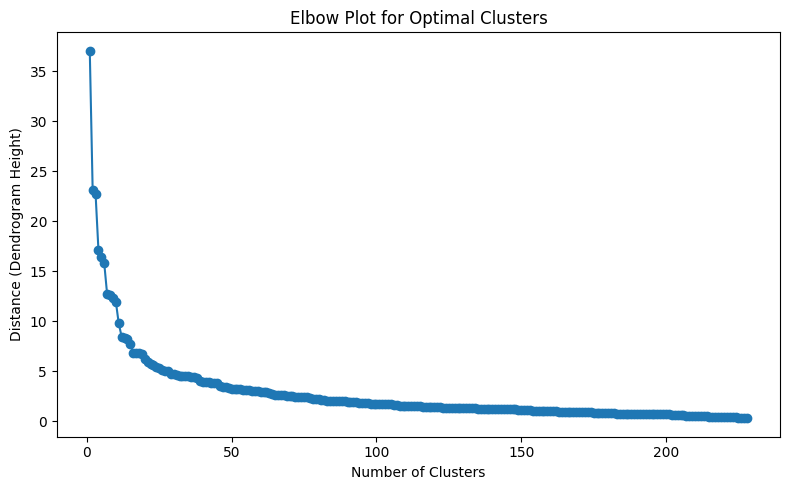

In [5]:
import pandas as pd

# Load the provided Excel file to inspect its contents
file_path = 'Medium_volatile_days(62.59 per cent)_Q3.xlsx'
xls = pd.ExcelFile(file_path)

# Check the sheet names to understand the structure of the file
xls.sheet_names

# Load the data from the first sheet to examine its structure
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Step 1: Convert the Datetime column to datetime objects and extract the time part
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Time'] = df['Datetime'].dt.time
df['Date'] = df['Datetime'].dt.date

# Define the time periods of interest
time_periods = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '00:00')
]

# Convert the time periods to time objects for comparison
time_periods = [(pd.to_datetime(start).time(), pd.to_datetime(end).time()) for start, end in time_periods]

# Step 2: Function to calculate max and std for each time segment
def calculate_features(group):
    features = {}
    for i, (start, end) in enumerate(time_periods):
        if start < end:
            # Filter rows within the time period (for segments within the same day)
            period_data = group[(group['Time'] >= start) & (group['Time'] < end)]
        else:
            # Handle overnight periods (crossing midnight)
            period_data = group[(group['Time'] >= start) | (group['Time'] < end)]

        # Calculate max and std for this period
        features[f'max_period_{i+1}'] = period_data['USEP (c/kWh)'].max()
        features[f'std_period_{i+1}'] = period_data['USEP (c/kWh)'].std()

    return pd.Series(features)

# Step 3: Group by Date and calculate the features
grouped = df.groupby('Date').apply(calculate_features).reset_index()

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Step 1: Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(grouped.iloc[:, 1:])  # Exclude the 'Date' column

# Step 2: Perform hierarchical clustering using 'ward' linkage method
linkage_matrix = linkage(scaled_data, method='ward')

# Step 3: Plot the dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(linkage_matrix, labels=grouped['Date'].astype(str).values, leaf_rotation=90, leaf_font_size=10)
plt.xlabel('Date')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Step 1: Calculate the distances (height in the dendrogram) at which clusters are merged
distances = linkage_matrix[:, 2]

# Step 2: Plot an "elbow" plot to visualize where the largest gap occurs (optimal number of clusters)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(distances) + 1), distances[::-1], marker='o')
plt.title('Elbow Plot for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance (Dendrogram Height)')
plt.tight_layout()
plt.show()


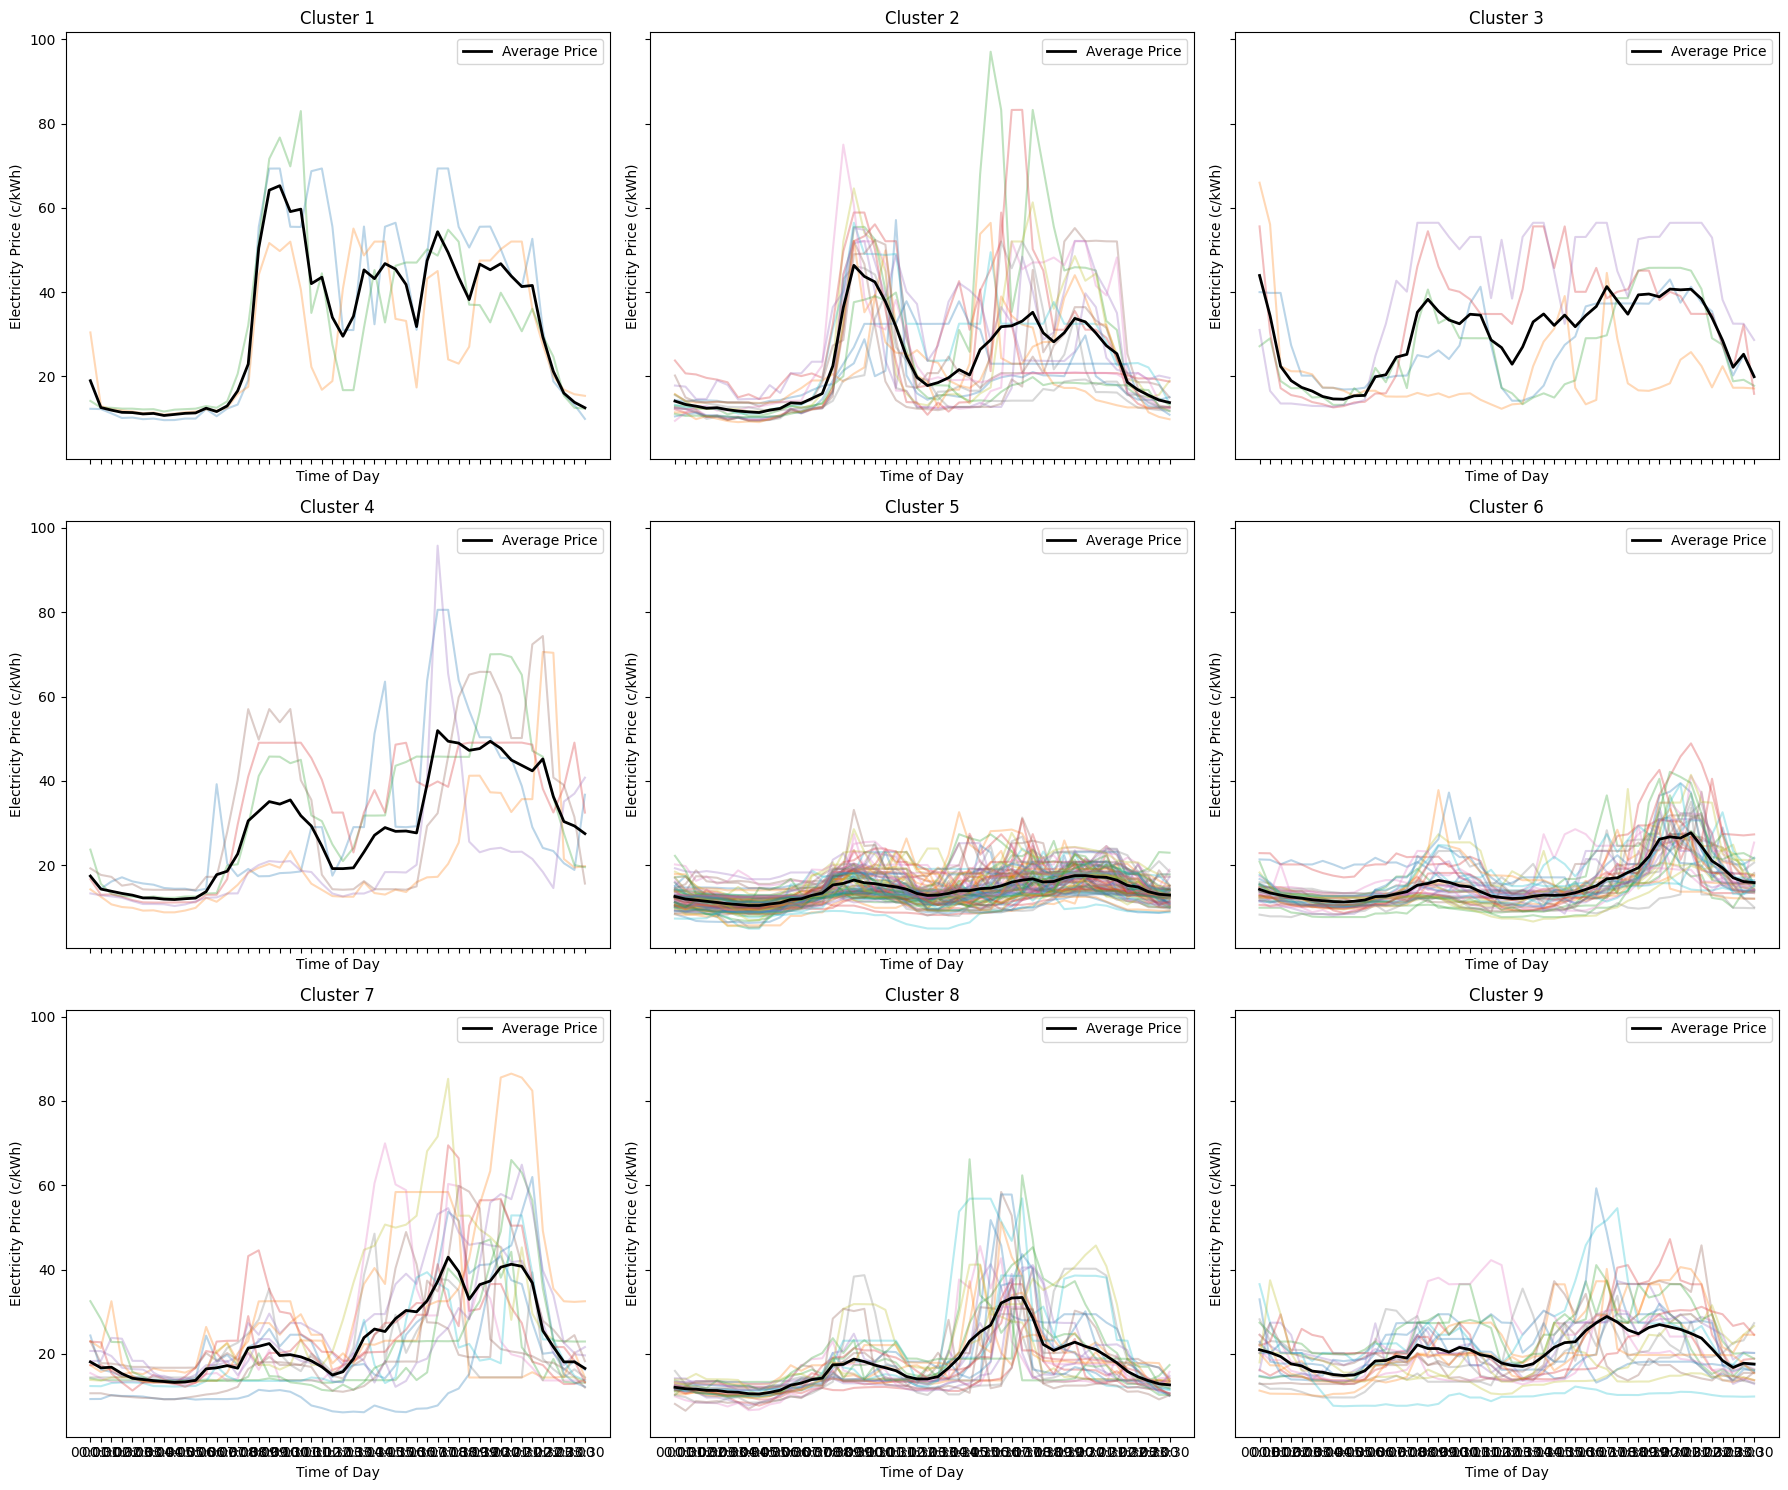

In [ ]:
from scipy.cluster.hierarchy import fcluster
df['Time'] = df['Datetime'].dt.strftime('%H:%M')

# Step 1: Perform clustering with 9 clusters
num_clusters = 9
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add the cluster labels to the original grouped data
grouped['Cluster'] = cluster_labels

# Step 2: Prepare a new plot with 9 clusters
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True, sharey=True)
axes = axes.flatten()

# Iterate over each cluster
for cluster_num in range(1, num_clusters + 1):
    cluster_days = grouped[grouped['Cluster'] == cluster_num]['Date']
    cluster_data = df[df['Date'].isin(cluster_days)]

    # Plot each day's electricity price in the cluster
    for day in cluster_days:
        day_data = cluster_data[cluster_data['Date'] == day]
        axes[cluster_num - 1].plot(day_data['Time'], day_data['USEP (c/kWh)'], alpha=0.3)

    # Calculate the average price for this cluster and plot it
    avg_price = cluster_data.groupby('Time')['USEP (c/kWh)'].mean()
    axes[cluster_num - 1].plot(avg_price.index, avg_price.values, color='black', label='Average Price', linewidth=2)

    axes[cluster_num - 1].set_title(f'Cluster {cluster_num}')
    axes[cluster_num - 1].set_xlabel('Time of Day')
    axes[cluster_num - 1].set_ylabel('Electricity Price (c/kWh)')
    axes[cluster_num - 1].legend()

plt.tight_layout()
plt.show()


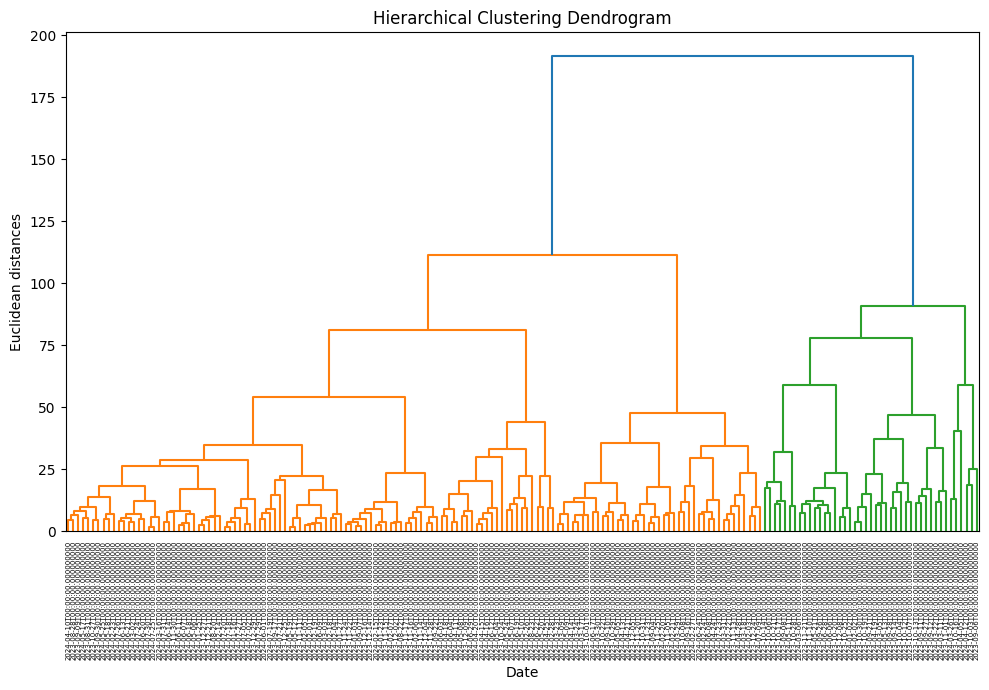

In [6]:
import pandas as pd

# Load the data from the uploaded file
file_path = 'Medium_volatile_days_max_under_50 (49.45 per cent)_Q3.xlsx'

xls = pd.ExcelFile(file_path)

# Checking sheet names to understand the structure of the file
xls.sheet_names

# Load the data from the first sheet
data = pd.read_excel(xls, sheet_name='Sheet1')

# Convert Datetime column to datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Define the time intervals for feature extraction
time_intervals = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '00:00')
]

# Extract the hour and minute from the Datetime column to match against intervals
data['Time'] = data['Datetime'].dt.time

# Prepare a list to store the feature extraction results
features_list = []

# Function to filter data by a specific time range within a day
def filter_by_time(data, start_time, end_time):
    if start_time < end_time:
        return data[(data['Time'] >= pd.to_datetime(start_time).time()) &
                    (data['Time'] < pd.to_datetime(end_time).time())]
    else:
        # Handle the time range that spans across midnight
        return data[(data['Time'] >= pd.to_datetime(start_time).time()) |
                    (data['Time'] < pd.to_datetime(end_time).time())]

# Extract features for each day
for day, day_data in data.groupby('Date'):
    day_features = {}
    day_features['Date'] = day

    for start_time, end_time in time_intervals:
        segment_data = filter_by_time(day_data, start_time, end_time)

        # Extract maximum and standard deviation for the segment
        max_value = segment_data['USEP (c/kWh)'].max()
        std_value = segment_data['USEP (c/kWh)'].std()

        # Store these features
        feature_prefix = f'{start_time}-{end_time}'
        day_features[f'{feature_prefix}_max'] = max_value
        day_features[f'{feature_prefix}_std'] = std_value

    features_list.append(day_features)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linked = linkage(features_df.drop(columns=['Date']), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=features_df['Date'].values, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Date')
plt.ylabel('Euclidean distances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


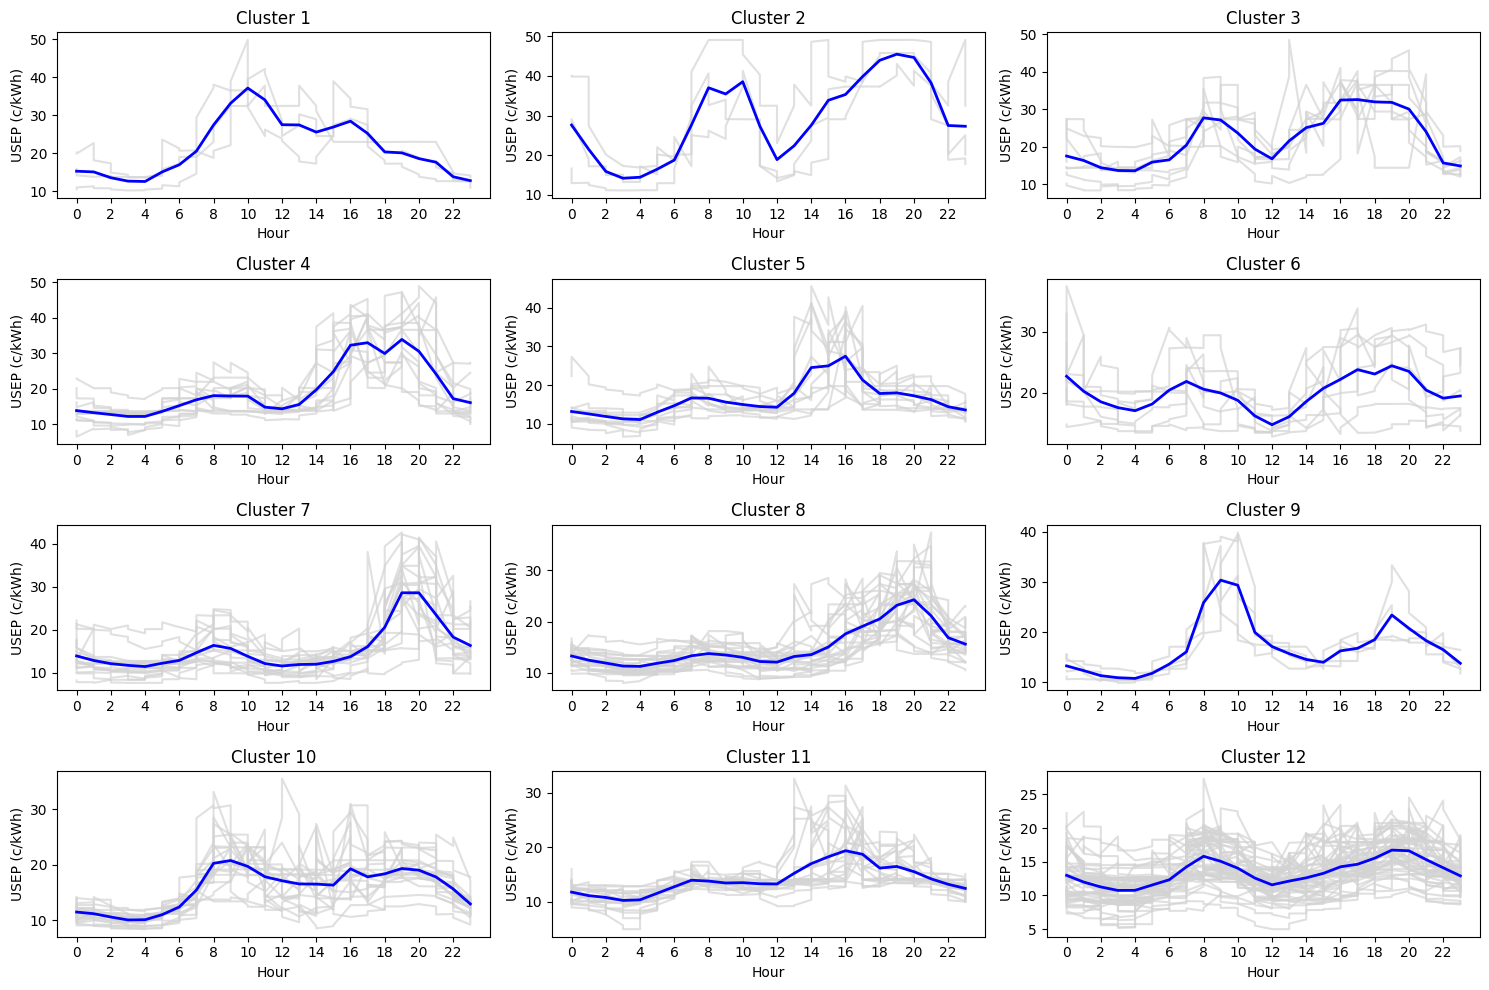

In [16]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Set the number of clusters
n_clusters = 12

# Perform hierarchical clustering and assign cluster labels
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# Add cluster labels to the features_df
features_df['Cluster'] = clusters

# Prepare data for plotting: average price per hour of each cluster
data['Hour'] = data['Datetime'].dt.hour

# Create a new DataFrame to store hourly average USEP per cluster
hourly_avg_per_cluster = pd.DataFrame()

plt.figure(figsize=(15, 10))  # Adjust the figure size for a 4x3 grid

for cluster_num in range(1, n_clusters + 1):
    plt.subplot(4, 3, cluster_num)  # Create a 4x3 grid of subplots

    cluster_dates = features_df[features_df['Cluster'] == cluster_num]['Date']
    cluster_data = data[data['Date'].isin(cluster_dates)]

    # Plot individual days
    for day in cluster_dates:
        day_data = cluster_data[cluster_data['Date'] == day]
        plt.plot(day_data['Hour'], day_data['USEP (c/kWh)'],color='lightgray', alpha=0.7)

    # Plot the average price for the cluster
    hourly_avg = cluster_data.groupby('Hour')['USEP (c/kWh)'].mean()
    plt.plot(hourly_avg.index, hourly_avg, color='blue', linewidth=2, label=f'Cluster {cluster_num} Avg')


    plt.title(f'Cluster {cluster_num}')
    plt.xlabel('Hour')
    plt.ylabel('USEP (c/kWh)')
    #plt.grid(True)

    plt.xticks(np.arange(0, 24, 2))

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the proportion of days in each cluster
cluster_counts = features_df['Cluster'].value_counts()
total_days = features_df['Cluster'].count()

# Create a DataFrame for the proportion of days in each cluster
cluster_proportions = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Number of Days': cluster_counts.values,
    'Proportion': (cluster_counts / total_days) * 100
})

cluster_proportions

,Cluster,Number of Days,Proportion
Cluster,,,
12,12,55,30.386740
8,8,24,13.259669
11,11,19,10.497238
10,10,19,10.497238
7,7,17,9.392265
4,4,12,6.629834
5,5,11,6.077348
6,6,7,3.867403
3,3,7,3.867403


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


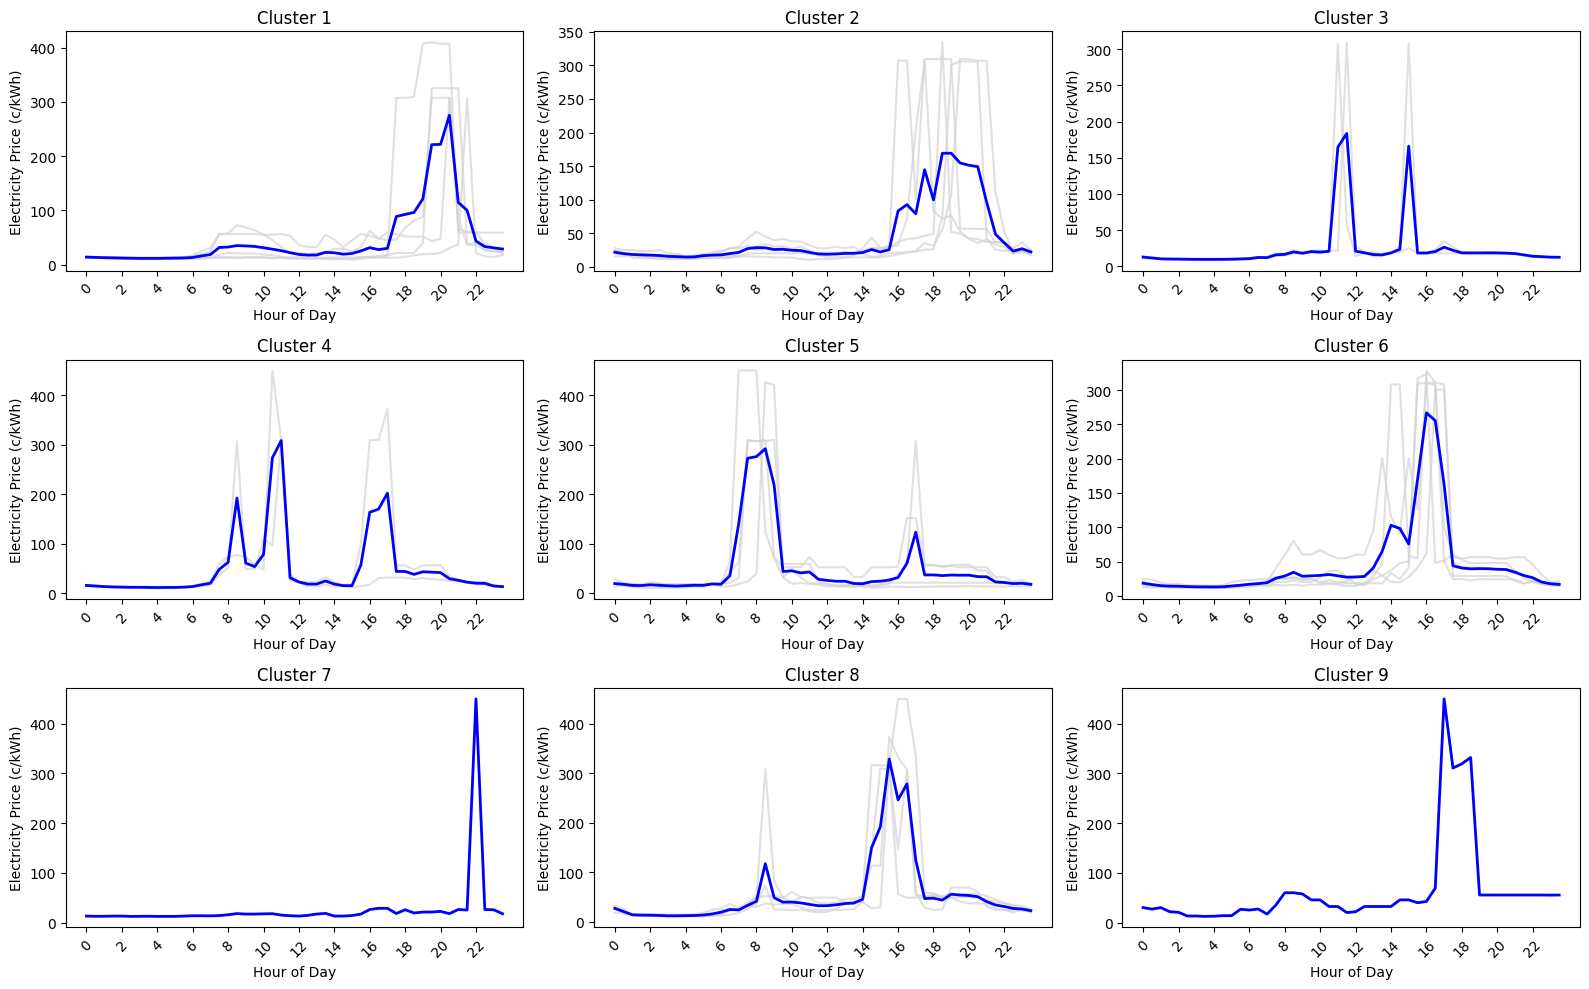

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load the data
file_path = 'Medium_volatile_days_max_above_50 (13.12 per cent)_Q3.xlsx'
file_path = 'High_Volatile_days(7.92 per cent).xlsx'
data = pd.read_excel(file_path)

# Convert Datetime column to datetime type
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Create a new column for the date to aggregate by days
data['Date'] = data['Datetime'].dt.date

# Define time segments
time_segments = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '00:00')
]

# Function to extract max and standard deviation for a time segment
def extract_features(df, start_time, end_time):
    mask = (df['Datetime'].dt.time >= pd.to_datetime(start_time).time()) & (df['Datetime'].dt.time < pd.to_datetime(end_time).time())
    segment_data = df[mask]
    return segment_data['USEP (c/kWh)'].max(), segment_data['USEP (c/kWh)'].std()

# Extract features for each day
features = []
for date, group in data.groupby('Date'):
    day_features = [date]
    for start_time, end_time in time_segments:
        max_price, std_price = extract_features(group, start_time, end_time)
        day_features.extend([max_price, std_price])
    features.append(day_features)

# Create a DataFrame for the features
columns = ['Date'] + [f'max_{i+1}' for i in range(6)] + [f'std_{i+1}' for i in range(6)]
features_df = pd.DataFrame(features, columns=columns)

# Drop the 'Date' column and fill NaN values in the numeric columns
features_df_clean = features_df.drop(columns=['Date']).fillna(features_df.drop(columns=['Date']).mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df_clean)

# Handle any remaining non-finite values (like NaN or inf)
scaled_features_clean = np.where(np.isfinite(scaled_features), scaled_features, 0)

# Hierarchical clustering
Z = linkage(scaled_features_clean, method='ward')
num_clusters = 9
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Add cluster labels to the original data
data['Cluster'] = None
for date, label in zip(features_df['Date'], cluster_labels):
    data.loc[data['Datetime'].dt.date == date, 'Cluster'] = label

# Convert time to hour fractions for plotting
data['Hour'] = data['Datetime'].dt.hour + data['Datetime'].dt.minute / 60

# Plot electricity price vs 24-hour day for each cluster
plt.figure(figsize=(16, 10))
for cluster_num in range(1, num_clusters + 1):
    cluster_data = data[data['Cluster'] == cluster_num]
    plt.subplot(3, 3, cluster_num)

    # Plot daily electricity prices
    for date, group in cluster_data.groupby(cluster_data['Datetime'].dt.date):
        plt.plot(group['Hour'], group['USEP (c/kWh)'], color='lightgray', alpha=0.7)

    # Plot average electricity price for the cluster
    avg_price = cluster_data.groupby('Hour')['USEP (c/kWh)'].mean()
    plt.plot(avg_price.index, avg_price.values, label='Average', color='blue', linewidth=2)

    plt.title(f'Cluster {cluster_num}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Electricity Price (c/kWh)')
    plt.xticks(rotation=45)
    #plt.legend()

    plt.xticks(np.arange(0, 24, 2))

plt.tight_layout()
plt.show()


In [24]:
# Recalculate the proportion of days in each cluster
cluster_proportions = data.groupby('Cluster')['Date'].nunique() / data['Date'].nunique() * 100

# Create a DataFrame to display the proportions
cluster_proportions_df = pd.DataFrame(cluster_proportions).reset_index()
cluster_proportions_df.columns = ['Cluster', 'Proportion of Days (%)']

cluster_proportions_df


,Cluster,Proportion of Days (%)
0,1,6.250000
1,2,10.416667
2,3,22.916667
3,4,16.666667
4,5,4.166667
5,6,2.083333
6,7,14.583333
7,8,4.166667
8,9,18.750000
